# TASK 0 : GRADIENT DESCENT


## Learning Goal

The goal of this notebook is to gain intuition for various gradient descent methods by visualizing and applying these methods to some simple two-dimensional surfaces. Methods studied include ordinary gradient descent, gradient descent with momentum, NAG, ADAM, and RMSProp.


## Overview

In this notebook, we will visualize what different gradient descent methods are doing using some simple surfaces. From the onset, we emphasize that doing gradient descent on the surfaces is different from performing gradient descent on a loss function in Machine Learning (ML). The reason is that in ML not only do we want to find good minima, we want to find good minima that generalize well to new data. Despite this crucial difference, we can still build intuition about gradient descent methods by applying them to simple surfaces (see related blog posts [here](http://ruder.io/optimizing-gradient-descent/) and [here](http://tiao.io/notes/visualizing-and-animating-optimization-algorithms-with-matplotlib/)).

## Surfaces

We will consider two simple surfaces: $$z=b(1 - e^{- \frac{1}{2}w(x^2 + y^2)}) + \frac{1}{2}q(-x^3 + y)^2$$ a saddle-point of the form $$z=ax^2-by^2,$$ and [Beale's Function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), a convex function often used to test optimization problems of the form:
$$z(x,y) = (1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2$$

These surfaces can be plotted using the cells below. 


In [45]:
%matplotlib inline

#Make 3D plots
from    mpl_toolkits.mplot3d import Axes3D
import  matplotlib.pyplot    as     plt
from    matplotlib           import cm
#from matplotlib import animation
from       IPython.display   import HTML
from       matplotlib.colors import LogNorm 
#Import Numpy
import  numpy                as np
import  time

In [46]:
def plot_surface(x, y, z, azim = -60, elev = 45, dist = 10, cmap = "RdYlBu_r"):
 
    fig       = plt.figure(figsize = (9,8))
    ax        = fig.add_subplot(111, projection = '3d')
    plot_args = {'rstride'  : 1, 'cstride'    : 1, 'cmap':cmap,
                'linewidth': 20, 'antialiased': True,}
    ax.plot_surface(x, y, z, **plot_args)
    ax.view_init(azim = azim, elev = elev)
    ax.dist           = dist
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)
    
    ax.set_xlabel("x", fontsize=18)
    ax.set_ylabel("y", fontsize=18)
    ax.set_zlabel("z", fontsize=18)
    return fig, ax;

def overlay_trajectory_quiver(ax,obj_func,trajectory, color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.quiver(xs[:-1], ys[:-1], zs[:-1], xs[1:]-xs[:-1], ys[1:]-ys[:-1],zs[1:]-zs[:-1],color=color,arrow_length_ratio=0.3)
    return ax;

def overlay_trajectory(ax,obj_func,trajectory,label,color='k'):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    zs=obj_func(xs,ys)
    ax.plot(xs,ys,zs, color, label=label)
    return ax;

def overlay_trajectory_contour_M(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    ax.plot(xs[-1],ys[-1],color+'>', markersize=14)
    return ax;

def overlay_trajectory_contour(ax,trajectory, label,color='k',lw=2):
    xs=trajectory[:,0]
    ys=trajectory[:,1]
    ax.plot(xs,ys, color, label=label,lw=lw)
    return ax;

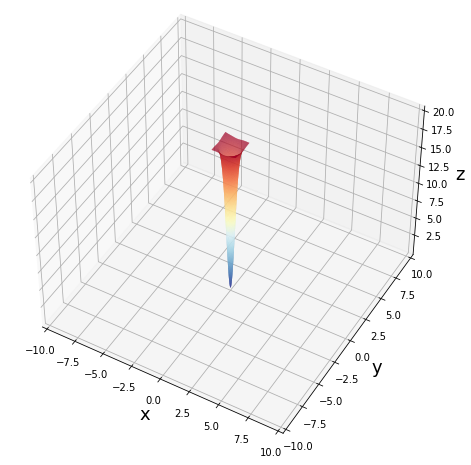

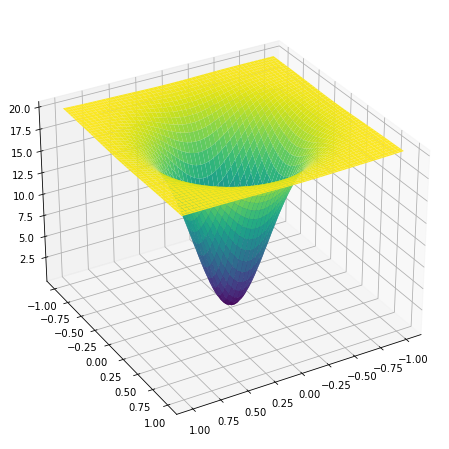

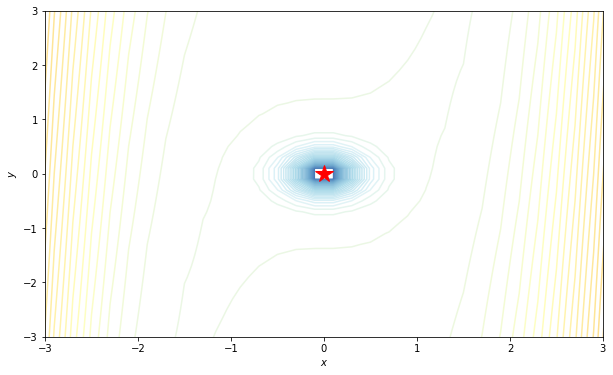

In [55]:
#DEFINE SURFACES WE WILL WORK WITH

def f (x, y, w = 10, q = 1/10, b = 20):
    return b * (1 - np.exp(- 0.5* w *(x**2 + y**2))) + 0.5*q*(-x**3 + y)**2

#def grad_x (x, y, w = 10, q = 1/10, b = 20):
#    return (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))

#def grad_y (x, y, w = 10, q = 1/10, b = 20):
#    return (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))

def grad_f (params, w = 10, q = 1/10, b = 20):
    x = params[0]
    y = params[1]
    grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
    grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
    return [grad_x,grad_y]

def contour_f():
    x, y = np.meshgrid(np.arange(-4.5, 4.5, 0.2), np.arange(-4.5, 4.5, 0.2))
    fig, ax = plt.subplots(figsize=(10, 6))
    z = f(x,y)
    cax = ax.contour(x, y, z, levels=np.logspace(0, 3, 100), norm=LogNorm(), cmap="RdYlBu_r")
    ax.plot(0,0, 'r*', markersize=18)
# aggiungere mappa
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')

    ax.set_xlim((-3, 3))
    ax.set_ylim((-3, 3))
    
    return fig,ax

#Make plots of surfaces

x         = np.linspace(-1, 1, 100)
y         = np.linspace(-1, 1, 100)
x, y      = np.mgrid[-1:1:100j, -1:1:100j]
fig1, ax1 = plot_surface(x,y, f(x,y))

X    = np.meshgrid(x, y)
fig  = plt.figure(figsize = (9,8))
ax   = fig.add_subplot(projection = '3d')

ax.plot_surface( x, y, f(x, y), cmap = 'viridis')
ax.view_init(30,60)
plt.show()

fig4,ax4 =contour_f()
plt.show()

# GRADIENT DESCENT METHODS

In [50]:
# 1 Vanilla
def gd( grad, init, n_epochs=1000, eta=10**-4, noise_strength=0 ):

    params         = np.array(init)
    param_traj     = np.zeros([n_epochs+1,2])
    param_traj[0,0] = init[0]
    param_traj[0,1] = init[1]
    v = 0;
    for j in range(n_epochs):
        noise  = noise_strength*np.random.randn(params.size)
        v      = eta*(np.array(grad(params))+noise)
        params =params - v
        param_traj[j+1,] = params
    return param_traj

# 2 Gradient descent with momentum
def gd_with_mom( grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0:]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        v=gamma*v+eta*(np.array(grad(params))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# 3 Nesterov (NAG)
def NAG(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        params_nesterov=params-gamma*v
        v=gamma*v+eta*(np.array(grad(params_nesterov))+noise)
        params=params-v
        param_traj[j+1,]=params
    return param_traj

# 4 RMSprop
def rms_prop(grad, init, n_epochs=5000, eta=10**-3, beta=0.9,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init#Import relevant packages
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v=eta*np.divide(g,np.sqrt(grad_sq+epsilon))
        params= params-v
        param_traj[j+1,]=params
    return param_traj
                        
# 5 ADAM                      
def adams(grad, init, n_epochs=5000, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,2])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

Define a grid Q of initial points equally
spaced in the square S=[-3,3]x[-3,3].
Perform a minimization starting from
each of the points in Q, and compute the
average value of the function vs time
during these minimizations, for each
method (with a good value of its own
learning rate, chosen after some test).

<ipython-input-98-4059a69fbf31>:6: UserWarning: Log scale: values of z <= 0 have been masked
  ax.contour(x, y, z, levels=np.logspace(0.0, 5, 50), norm=LogNorm(), cmap="RdYlBu_r")


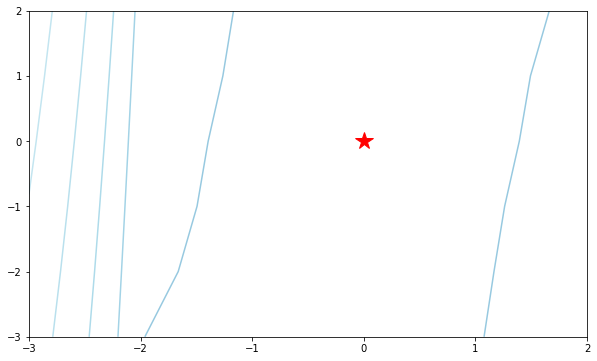

<ipython-input-55-160164647ae6>:15: RuntimeWarning: overflow encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: overflow encountered in double_scalars
  grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:15: RuntimeWarning: invalid value encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: invalid value encountered in double_scalars
  grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:15: RuntimeWarning: overflow encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: overflow encountered in double_scalars
  grad_y= (b * np.e

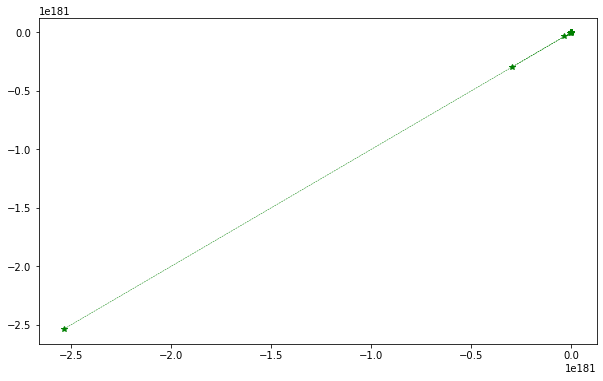

In [98]:
plt.close()

x, y    = np.meshgrid(np.arange(-3, 3, 1), np.arange(-3, 3, 1))
fig, ax = plt.subplots(figsize=(10, 6))
z       = np.abs(f(x,y))
ax.contour(x, y, z, levels=np.logspace(0.0, 5, 50), norm=LogNorm(), cmap="RdYlBu_r")
ax.plot(0,0, 'r*', markersize=18)
plt.show()
plt.close()
fig, ax = plt.subplots(figsize=(10, 6))
N =len(np.arange(-3, 3, 1))
eta = [0.1, 0.5, 1, 1.01, 2, 0.3]
epochs = [100, 100, 100, 10, 1, 100]
for i in range (N):
    for j in range (N):
        init = [-3 + i/N, -3 + j/N]
        gd_1 = gd(grad_f, init, n_epochs=10, eta = eta[i], noise_strength=0 )
        overlay_trajectory_contour(ax, gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
plt.show()


<ipython-input-55-160164647ae6>:15: RuntimeWarning: overflow encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: overflow encountered in double_scalars
  grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:15: RuntimeWarning: invalid value encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: invalid value encountered in double_scalars
  grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
No handles with labels found to put in legend.


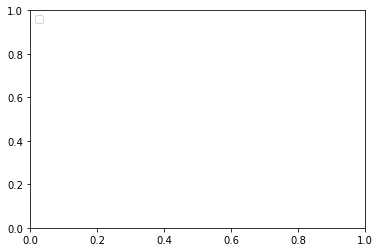

In [76]:
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1 = gd(grad_f, init, n_epochs=10, eta=10**-4, noise_strength=0 )
gd_2 = gd(grad_f,init2, n_epochs=100, eta=eta2)
gd_3 = gd(grad_f, init3, n_epochs=100, eta=eta3)
gd_4 = gd(grad_f, init4, n_epochs=10, eta=eta4)

overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)

plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')

<ipython-input-55-160164647ae6>:15: RuntimeWarning: overflow encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: overflow encountered in double_scalars
  grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:15: RuntimeWarning: invalid value encountered in double_scalars
  grad_x= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
<ipython-input-55-160164647ae6>:16: RuntimeWarning: invalid value encountered in double_scalars
  grad_y= (b * np.exp(- 0.5* w *(x**2 + y**2))* w * x) - (3* q * x**2 * (-x**3 + y))
No handles with labels found to put in legend.


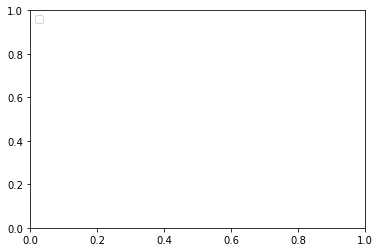

In [72]:
#initial point
init1=[-2,4]
init2=[-1.7,4]
init3=[-1.5,4]
init4=[-3,4.5]
eta1=0.1
eta2=0.5
eta3=1
eta4=1.01
gd_1=gd(grad_f,init1, n_epochs=100, eta=eta1)
gd_2=gd(grad_f,init2, n_epochs=100, eta=eta2)
gd_3=gd(grad_f,init3, n_epochs=100, eta=eta3)
gd_4=gd(grad_f,init4, n_epochs=10, eta=eta4)
#print(gd_1)
overlay_trajectory_contour(ax,gd_1,'$\eta=$%s'% eta1,'g--*', lw=0.5)
overlay_trajectory_contour(ax,gd_2,'$\eta=$%s'% eta2,'b-<', lw=0.5)
overlay_trajectory_contour(ax,gd_3,'$\eta=$%s'% eta3,'->', lw=0.5)
overlay_trajectory_contour(ax,gd_4,'$\eta=$%s'% eta4,'c-o', lw=0.5)
plt.legend(loc=2)
plt.show()
fig.savefig("GD3regimes.pdf", bbox_inches='tight')